<h1 style="background-color:#1aff1a;font-family:ALGERIAN;font-size:350%;text-align:center;border-radius: 15px 15px;padding: 5px">SUICIDE THOUGHTS ?</h1>


<center><img src="https://www.humanium.org/en/wp-content/uploads/2019/09/shutterstock_1140282473-scaled.jpg",height='500',width='600'></center>

<font style="color:black;font-family:ALGERIAN;font-size:150%;padding: 15px">The dataset is a collection of posts from "SuicideWatch" and "depression" subreddits of the Reddit platform. The posts are collected using Pushshift API. All posts that were made to "SuicideWatch" from Dec 16, 2008(creation) till Jan 2, 2021, were collected while "depression" posts were collected from Jan 1, 2009, to Jan 2, 2021.</font>

<center><img src="https://cropwatch.unl.edu/2019-CW-News/2019-images/Extension/signs-of-suicidal-thoughts.png",height='500',width='600'></center>

<h1 style="background-color:#1afCCC;font-family:ALGERIAN;font-size:250%;text-align:center;border-radius: 15px 15px;padding: 5px">LIBRARIES USED</h1>


In [1]:
from wordcloud import WordCloud
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
!pip install neattext
import neattext.functions as nfx
import matplotlib.pyplot as plt
import plotly.express as plx
from sklearn.metrics import classification_report
import keras
from keras.layers import Embedding,Dense,LSTM,Bidirectional,GlobalMaxPooling1D,Input,Dropout
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.models import Sequential
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

     |████████████████████████████████| 112 kB 878 kB/s 


In [2]:
data=pd.read_csv('../input/suicide-watch/Suicide_Detection.csv')
data.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [3]:
data['class'].value_counts()

non-suicide    116037
suicide        116037
Name: class, dtype: int64

In [4]:
data['class'].value_counts().index.values

array(['non-suicide', 'suicide'], dtype=object)

<h1 style="background-color:#1afCCC;font-family:ALGERIAN;font-size:250%;text-align:center;border-radius: 15px 15px;padding: 5px">DATA-SET SPLIT</h1>


In [5]:
train_data,test_data=train_test_split(data,test_size=0.2,random_state=10)

<h1 style="background-color:#1afCCC;font-family:ALGERIAN;font-size:250%;text-align:center;border-radius: 15px 15px;padding: 5px">DATA VISUALISATIONS</h1>


In [6]:
train_data['class'].value_counts().index.values

array(['suicide', 'non-suicide'], dtype=object)

In [7]:
plx.bar(train_data,x=train_data['class'].value_counts().index.values,
        y=train_data['class'].value_counts(),color=['Suicide','Not Suicide'])

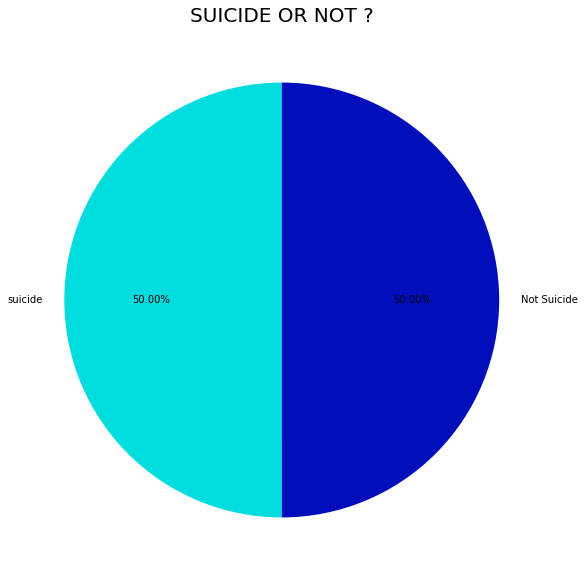

In [8]:
plt.figure(figsize=(12,10))
plt.pie(train_data['class'].value_counts(),startangle=90,colors=['#00dddf','#000fbb'],
        autopct='%0.2f%%',labels=['suicide','Not Suicide'])
plt.title('SUICIDE OR NOT ?',fontdict={'size':20})
plt.show()

<h1 style="background-color:#1afCCC;font-family:ALGERIAN;font-size:250%;text-align:center;border-radius: 15px 15px;padding: 5px">DATA CLEANING</h1>


In [9]:

def clean_text(text):
    text_length=[]
    cleaned_text=[]
    for sent in tqdm(text):
        sent=sent.lower()
        sent=nfx.remove_special_characters(sent)
        sent=nfx.remove_stopwords(sent)
#         sent=nfx.remove_shortwords(sent)
        text_length.append(len(sent.split()))
        cleaned_text.append(sent)
    return cleaned_text,text_length

In [10]:
cleaned_train_text,train_text_length=clean_text(train_data.text)
cleaned_test_text,test_text_length=clean_text(test_data.text)

100%|██████████| 46415/46415 [00:03<00:00, 12288.40it/s]


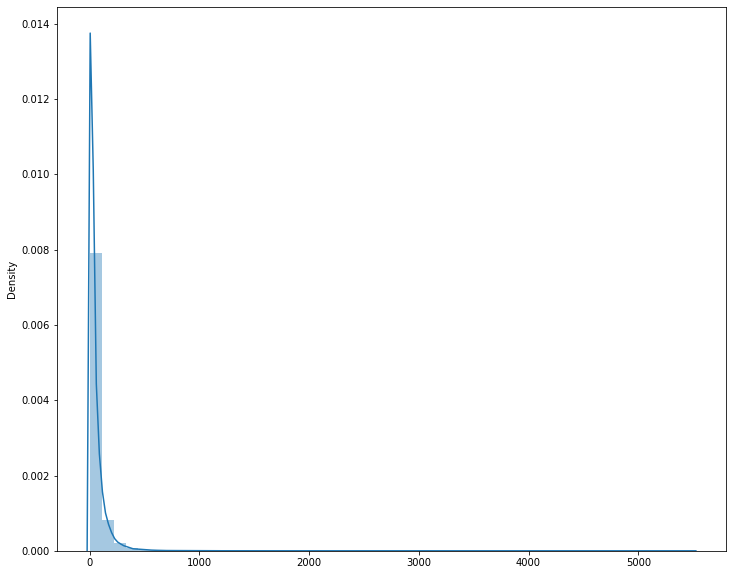

In [11]:
plt.figure(figsize=(12,10))
sns.distplot(train_text_length)
# plt.axis([-10,100,0,0.03])
plt.show()

In [12]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(cleaned_train_text)

In [13]:
word_freq=pd.DataFrame(tokenizer.word_counts.items(),columns=['word','count']).sort_values(by='count',ascending=False)

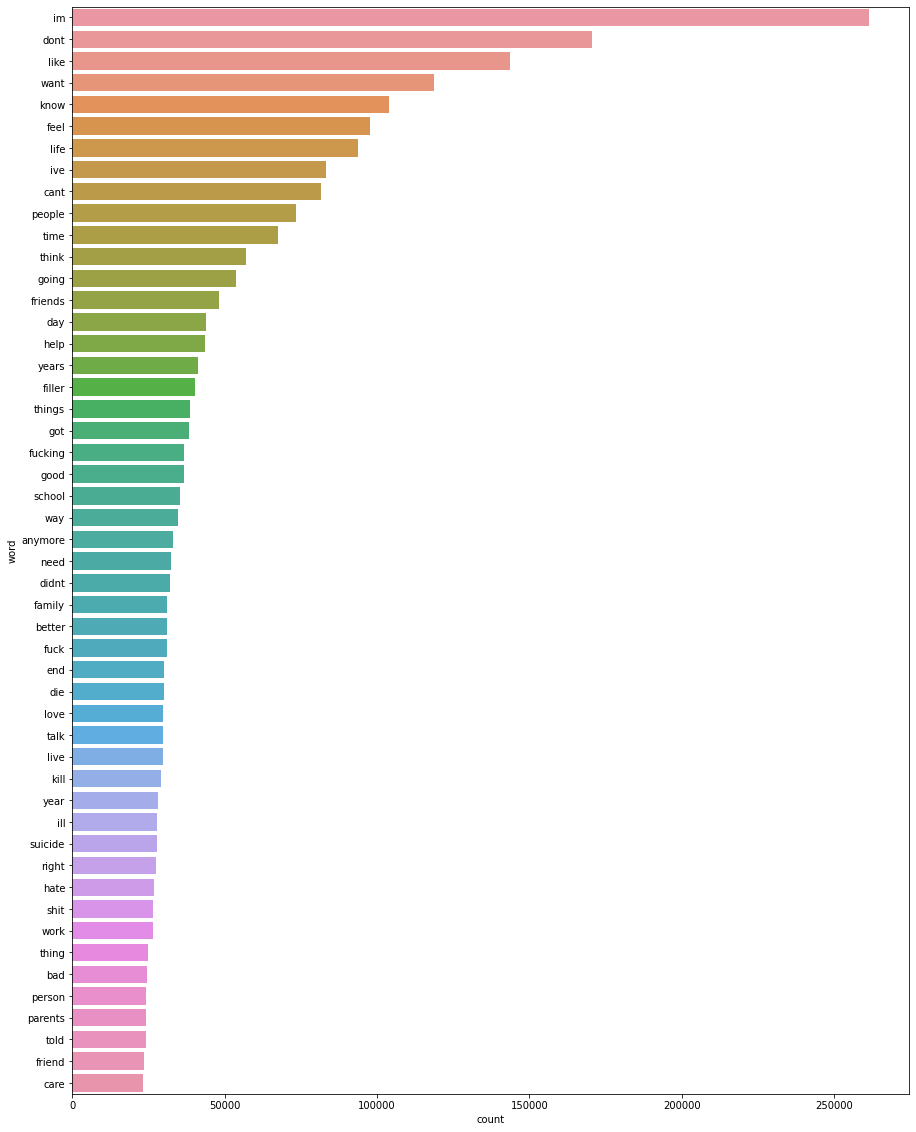

In [14]:
plt.figure(figsize=(15,20))
sns.barplot(x='count',y='word',data=word_freq.iloc[:50])
plt.show()

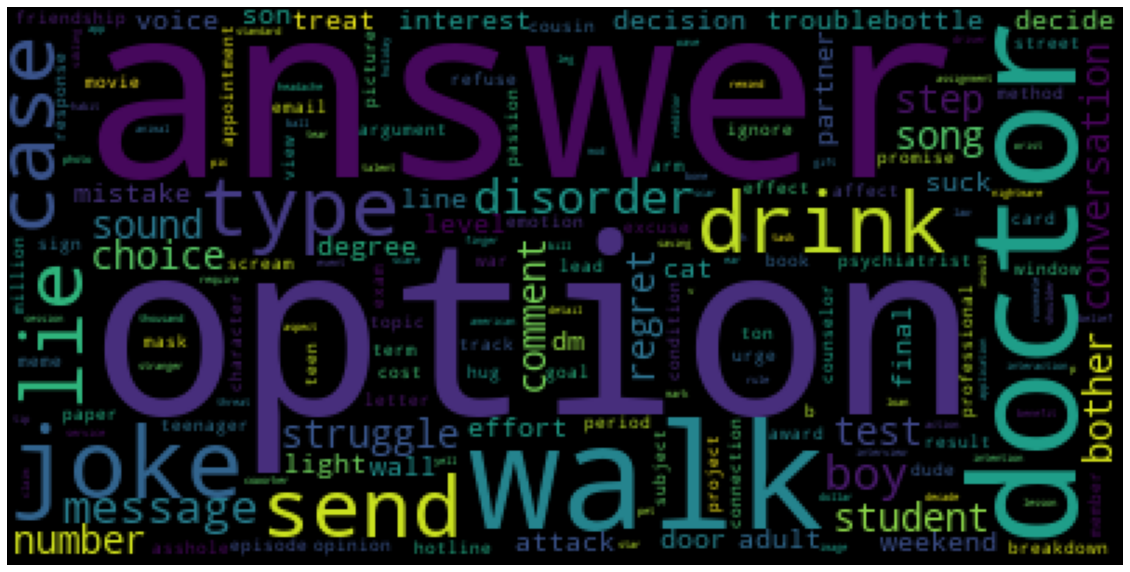

In [15]:
feature_names=word_freq['word'].values
wc=WordCloud(max_words=400)
wc.generate(' '.join(word for word in feature_names[500:3500] ))
plt.figure(figsize=(20,15))
plt.axis('off')
plt.imshow(wc)

<h1 style="background-color:#1afCCC;font-family:ALGERIAN;font-size:250%;text-align:center;border-radius: 15px 15px;padding: 5px">PREPROCESSING TEXT DATA</h1>


In [16]:
train_text_seq=tokenizer.texts_to_sequences(cleaned_train_text)
train_text_pad=pad_sequences(train_text_seq,maxlen=50)


test_text_seq=tokenizer.texts_to_sequences(cleaned_test_text)
test_text_pad=pad_sequences(test_text_seq,maxlen=50)

In [17]:
lbl_target=LabelEncoder()
train_output=lbl_target.fit_transform(train_data['class'])
test_output=lbl_target.transform(test_data['class'])

<h1 style="background-color:#1afCCC;font-family:ALGERIAN;font-size:250%;text-align:center;border-radius: 15px 15px;padding: 5px">GLOVE EMBEDDINGS</h1>


In [18]:
# glove_embedding={}
with open('../input/pickled-glove840b300d-for-10sec-loading/glove.840B.300d.pkl', 'rb') as fp:
    glove_embedding = pickle.load(fp)

In [19]:
v=len(tokenizer.word_index)

embedding_matrix=np.zeros((v+1,300), dtype=float)
for word,idx in tokenizer.word_index.items():
    embedding_vector=glove_embedding.get(word)
    if embedding_vector is not None:
        embedding_matrix[idx]=embedding_vector

In [20]:
early_stop=EarlyStopping(patience=5)
reducelr=ReduceLROnPlateau(patience=3)

<h1 style="background-color:#1afCCC;font-family:ALGERIAN;font-size:250%;text-align:center;border-radius: 15px 15px;padding: 5px">MODEL BUILDING</h1>


In [21]:
model=Sequential()
model.add(Input(shape=(40,)))
model.add(Embedding(v+1,300,weights=[embedding_matrix],trainable=False))
model.add(LSTM(20,return_sequences=True))
model.add(GlobalMaxPooling1D())
#     model.add(Dropout(0.3))
model.add(Dense(256,activation='relu'))
#     model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer=keras.optimizers.SGD(0.1,momentum=0.09),loss='binary_crossentropy',metrics=['accuracy'])

In [22]:
r=model.fit(train_text_pad,train_output,validation_data=(test_text_pad,test_output),
            epochs=20,batch_size=256,callbacks=[early_stop,reducelr])

Epoch 1/20
726/726 [==============================] - 19s 13ms/step - loss: 0.4612 - accuracy: 0.7741 - val_loss: 0.2982 - val_accuracy: 0.8771
Epoch 2/20
726/726 [==============================] - 9s 12ms/step - loss: 0.2597 - accuracy: 0.8957 - val_loss: 0.2347 - val_accuracy: 0.9067
Epoch 3/20
726/726 [==============================] - 9s 13ms/step - loss: 0.2326 - accuracy: 0.9076 - val_loss: 0.2174 - val_accuracy: 0.9148
Epoch 4/20
726/726 [==============================] - 8s 12ms/step - loss: 0.2202 - accuracy: 0.9132 - val_loss: 0.3076 - val_accuracy: 0.8761
Epoch 5/20
726/726 [==============================] - 9s 12ms/step - loss: 0.2100 - accuracy: 0.9182 - val_loss: 0.3616 - val_accuracy: 0.8521
Epoch 6/20
726/726 [==============================] - 9s 12ms/step - loss: 0.1983 - accuracy: 0.9238 - val_loss: 0.2038 - val_accuracy: 0.9206
Epoch 7/20
726/726 [==============================] - 9s 13ms/step - loss: 0.1837 - accuracy: 0.9289 - val_loss: 0.1891 - val_accuracy: 0.926

<h1 style="background-color:#1afCCC;font-family:ALGERIAN;font-size:250%;text-align:center;border-radius: 15px 15px;padding: 5px">MODEL EVALUATION</h1>


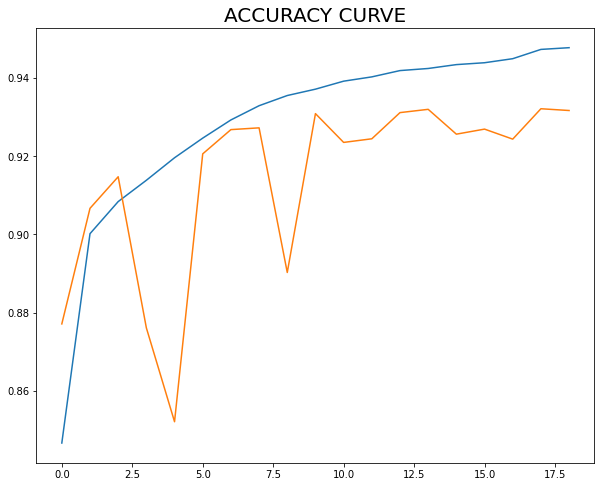

In [23]:
plt.figure(figsize=(10,8))
plt.plot(r.history['accuracy'])
plt.plot(r.history['val_accuracy'])
plt.title('ACCURACY CURVE',fontdict={'size':20})
plt.show()

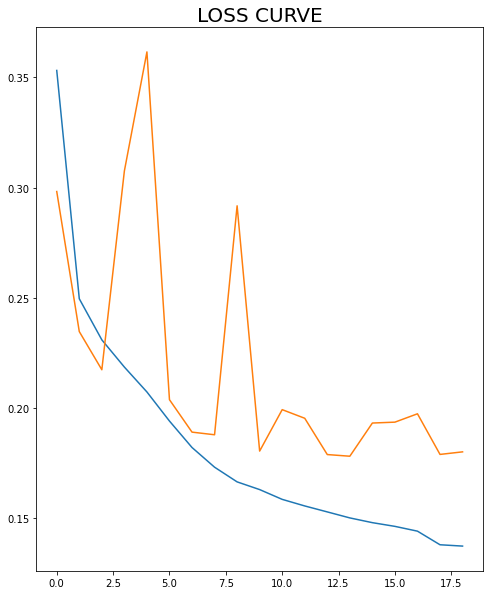

In [24]:
plt.figure(figsize=(8,10))
plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])
plt.title('LOSS CURVE',fontdict={'size':20})
plt.show()

In [25]:
print('TESTING DATA CLASSIFICATION REPORT \n \n')
print(classification_report(test_output,model.predict_classes(test_text_pad),
                            target_names=lbl_target.inverse_transform([0,1])))

print('TRAINING DATA CLASSIFICATION REPORT \n \n')
print(classification_report(train_output,model.predict_classes(train_text_pad),
                           target_names=lbl_target.inverse_transform([0,1])))

TESTING DATA CLASSIFICATION REPORT 
 

              precision    recall  f1-score   support

 non-suicide       0.92      0.95      0.93     23209
     suicide       0.95      0.92      0.93     23206

    accuracy                           0.93     46415
   macro avg       0.93      0.93      0.93     46415
weighted avg       0.93      0.93      0.93     46415

TRAINING DATA CLASSIFICATION REPORT 
 

              precision    recall  f1-score   support

 non-suicide       0.95      0.95      0.95     92828
     suicide       0.95      0.95      0.95     92831

    accuracy                           0.95    185659
   macro avg       0.95      0.95      0.95    185659
weighted avg       0.95      0.95      0.95    185659



<h1 style="background-color:#1afCCC;font-family:ALGERIAN;font-size:250%;text-align:center;border-radius: 15px 15px;padding: 5px">CONCLUSION</h1>


### The above created model perfectly fits the datasets. With training accuracy of about 94% and testing accuracy of about 93%. This model is very appropriate and can be used to detect suicidal thoughts.

<font style="color:red;font-family:ALGERIAN;font-size:150%;text-align:center;padding: 5px">Hope you liked the notebook !!! If yes, please upvote it. If having any queries or suggestion fell free to put yours thought in comment section.</font>